In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import gamma, poisson
import epyestim
import epyestim.covid19 as covid19
import epyestim.deconvolution as deconvolution
import epyestim.bootstrap as bootstrap
import epyestim.smoothen as smoothen
import os
from functions import _synthetic_infections as sim_inf
import functions
import scipy.linalg as la

In [2]:
UIUC_data = pd.read_csv("illinois_shield_covid_data_Updated.csv", parse_dates = [0])

# We only need aggregated daily positive cases and daily tests.
del UIUC_data["undergradCases"]
del UIUC_data["undergradTests"]
del UIUC_data["gradCases"]
del UIUC_data["gradTests"]
del UIUC_data["facStaffCases"]
del UIUC_data["facStaffTests"]

In [3]:
UIUC_data.rename(columns={"_time":"Date"},inplace= True)
UIUC_data.rename(columns={"totalNewCases":"Cases"},inplace= True)
UIUC_data.rename(columns={"totalNewTests":"Tests"},inplace= True)
UIUC_data = UIUC_data.loc[: 260]

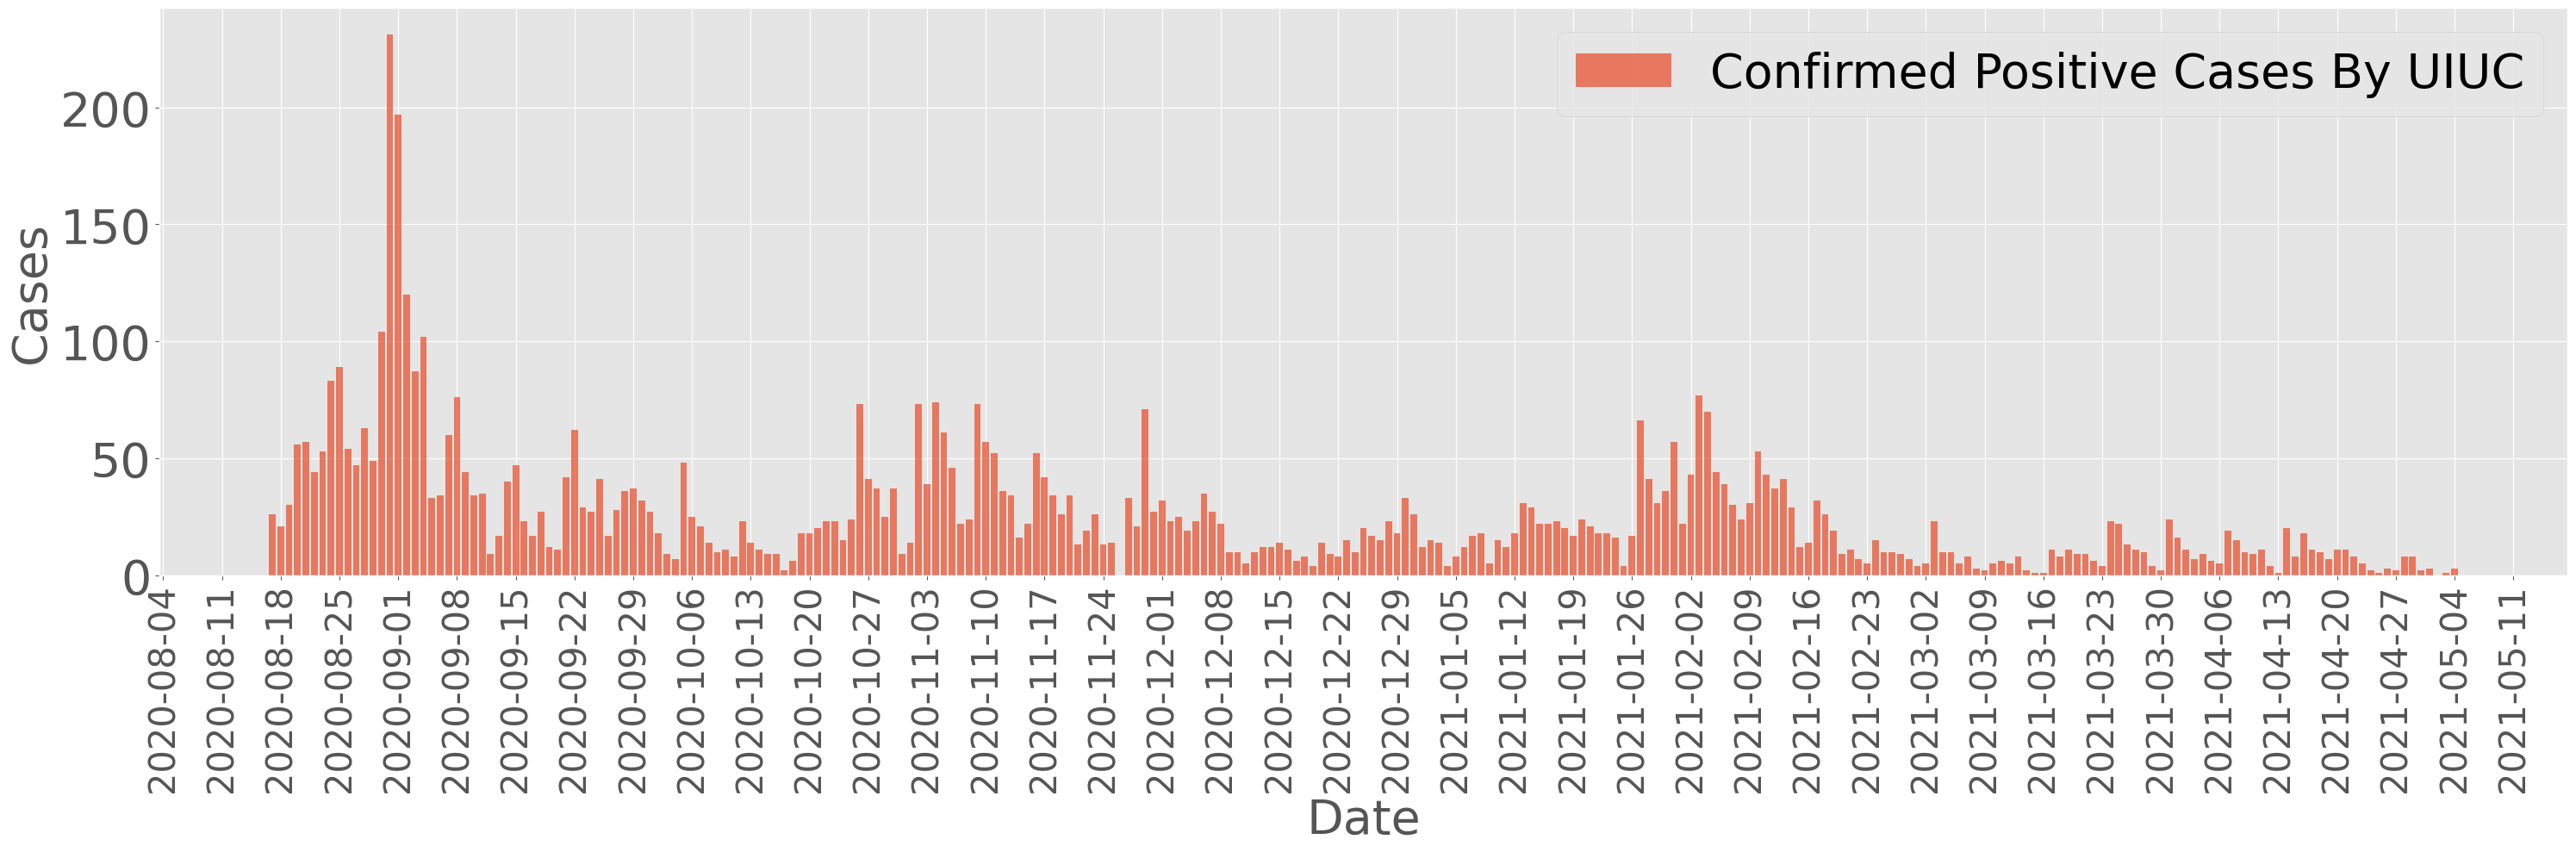

In [4]:
plt.style.use('ggplot')
fig, uiuc = plt.subplots(figsize=(30,10))
uiuc.bar(UIUC_data.Date, UIUC_data.Cases, color=(232/255, 74/255, 39/255, 0.7), label = 'Confirmed Positive Cases By UIUC')
uiuc.xaxis.set_major_locator(mdates.WeekdayLocator())
uiuc.legend(fontsize = 40)
uiuc.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
uiuc.tick_params(axis='x', rotation=90)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 40)
#uiuc.set_title('Confirmed Positive Cases During Fall 2020 at UIUC', fontsize = 20)
uiuc.set_ylabel('Cases')
uiuc.set_xlabel('Date')
uiuc.xaxis.label.set_size(40)
uiuc.yaxis.label.set_size(40)
plt.gcf().set_size_inches(30, 10)

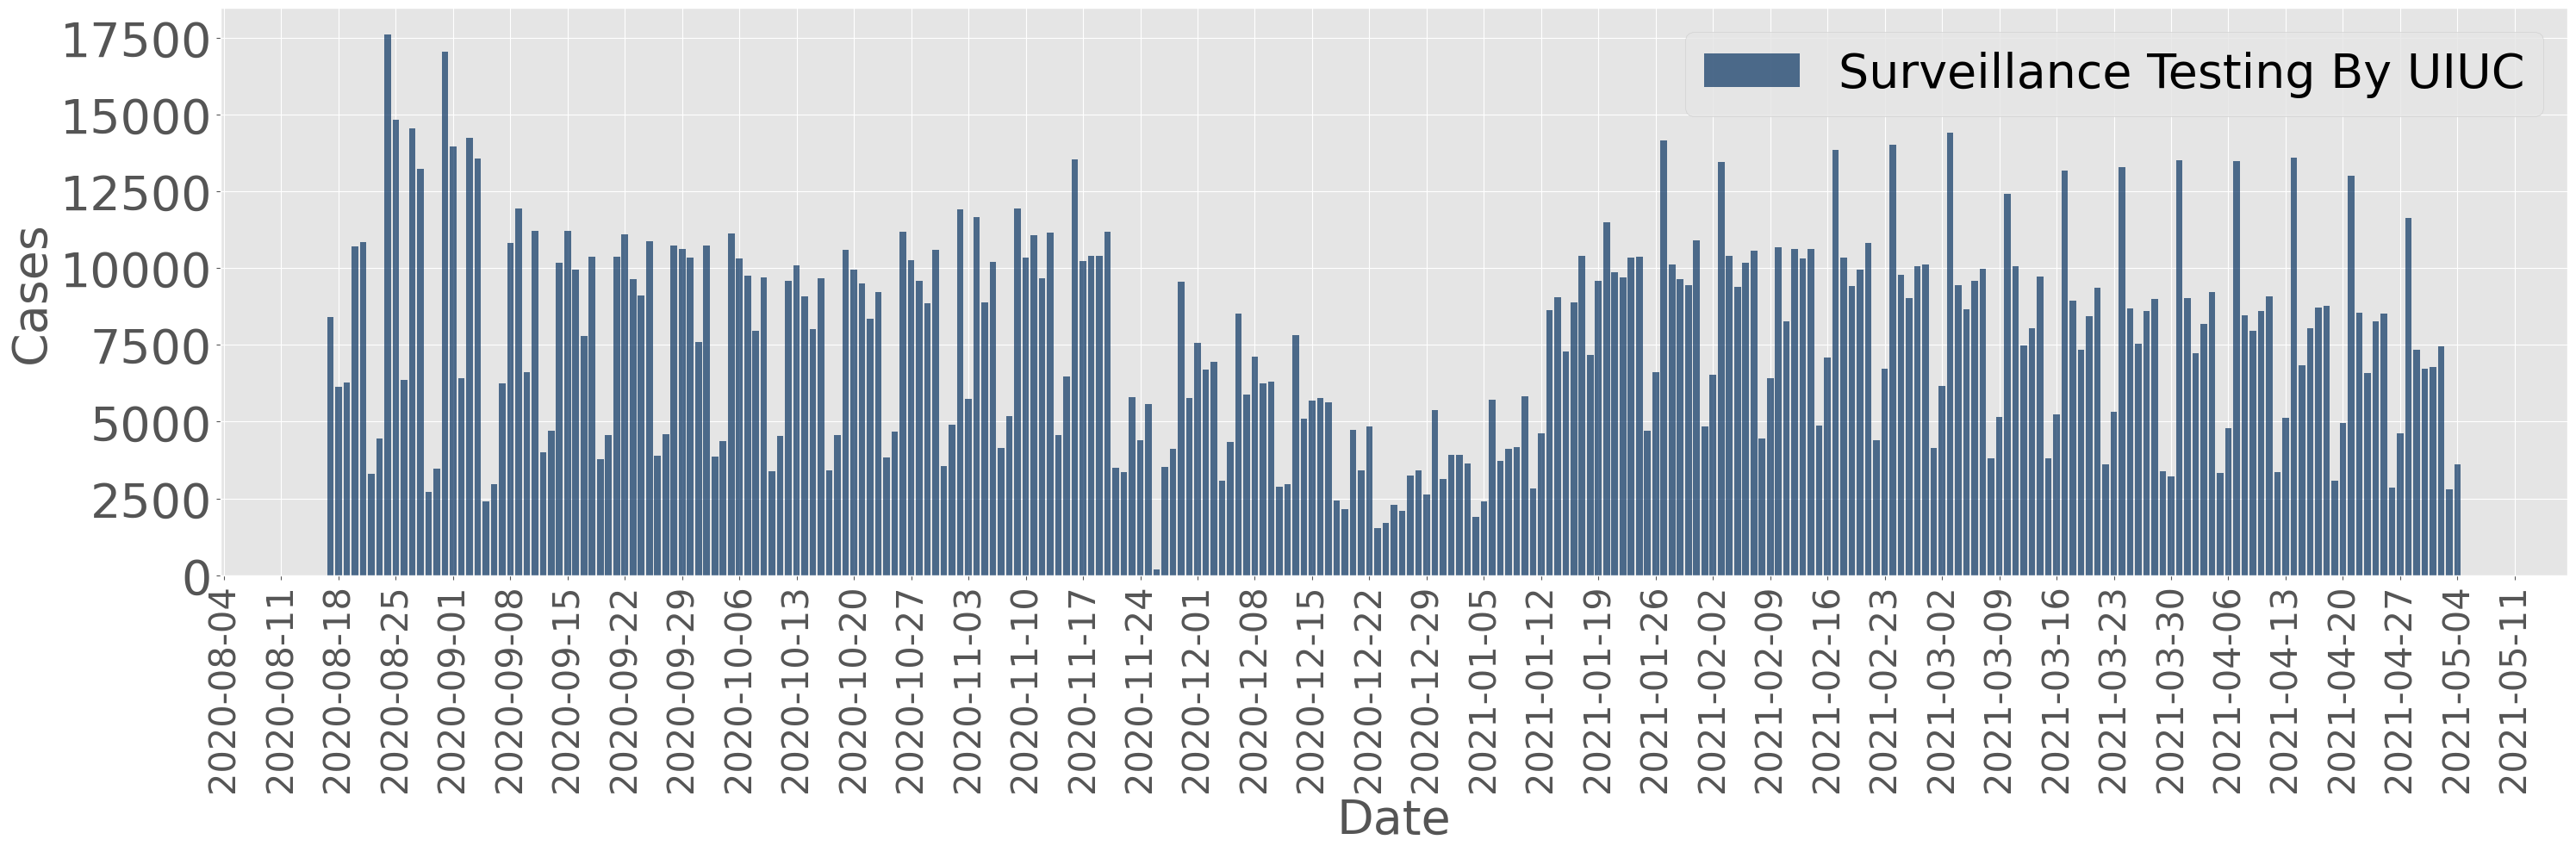

In [5]:
plt.style.use('ggplot')
fig, uiuc = plt.subplots(figsize=(30,10))
uiuc.bar(UIUC_data.Date, UIUC_data.Tests, color=(10/255, 52/255, 99/255, 0.7), label = 'Surveillance Testing By UIUC')
uiuc.xaxis.set_major_locator(mdates.WeekdayLocator())
uiuc.legend(fontsize = 40)
uiuc.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
uiuc.tick_params(axis='x', rotation=90)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 40)
#uiuc.set_title('Confirmed Positive Cases During Fall 2020 at UIUC', fontsize = 20)
uiuc.set_ylabel('Cases')
uiuc.set_xlabel('Date')
uiuc.xaxis.label.set_size(40)
uiuc.yaxis.label.set_size(40)
plt.gcf().set_size_inches(30, 10)

In [6]:
# Update infection profile
serial_UIUC = np.array([0.0000000001,0.0000000001, 0.148, 1.0, 0.823, 0.426, 0.202, 0.078, 0.042, 0.057, 0.009])
serial_UIUC_U = serial_UIUC / np.sum(serial_UIUC)

In [7]:
# U of Illinois tests everyone twice a week during Fall 2020
Ctrl_in = 2/7;
serial_UIUC_New = serial_UIUC-serial_UIUC
serial_UIUC_New[0]= serial_UIUC[0]
serial_UIUC_New[1]= serial_UIUC[1]

for x in range(2,len(serial_UIUC_New)):
    serial_UIUC_New [x] = (1-Ctrl_in)**(x-1)*serial_UIUC[x]

In [8]:
serial_UIUC_New = np.delete(serial_UIUC_New, [0])
serial_UIUC_New_U = serial_UIUC_New / np.sum(serial_UIUC_New)

In [9]:
del UIUC_data["Tests"]
UIUC_data.set_index('Date', inplace=True)
UIUC_Total_Confirm = UIUC_data.squeeze()

In [10]:
# adjust the estiamtion window
UIUC_R= covid19.r_covid(UIUC_Total_Confirm,gt_distribution=serial_UIUC_New_U,smoothing_window=21, r_window_size=14)
UIUC_R_1= covid19.r_covid(UIUC_Total_Confirm,gt_distribution=serial_UIUC_New_U,smoothing_window=21, r_window_size=21)
UIUC_R_2= covid19.r_covid(UIUC_Total_Confirm,gt_distribution=serial_UIUC_New_U,smoothing_window=21, r_window_size=28)

(array([0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6]),
 [Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2'),
  Text(0, 1.4, '1.4'),
  Text(0, 1.6, '1.6')])

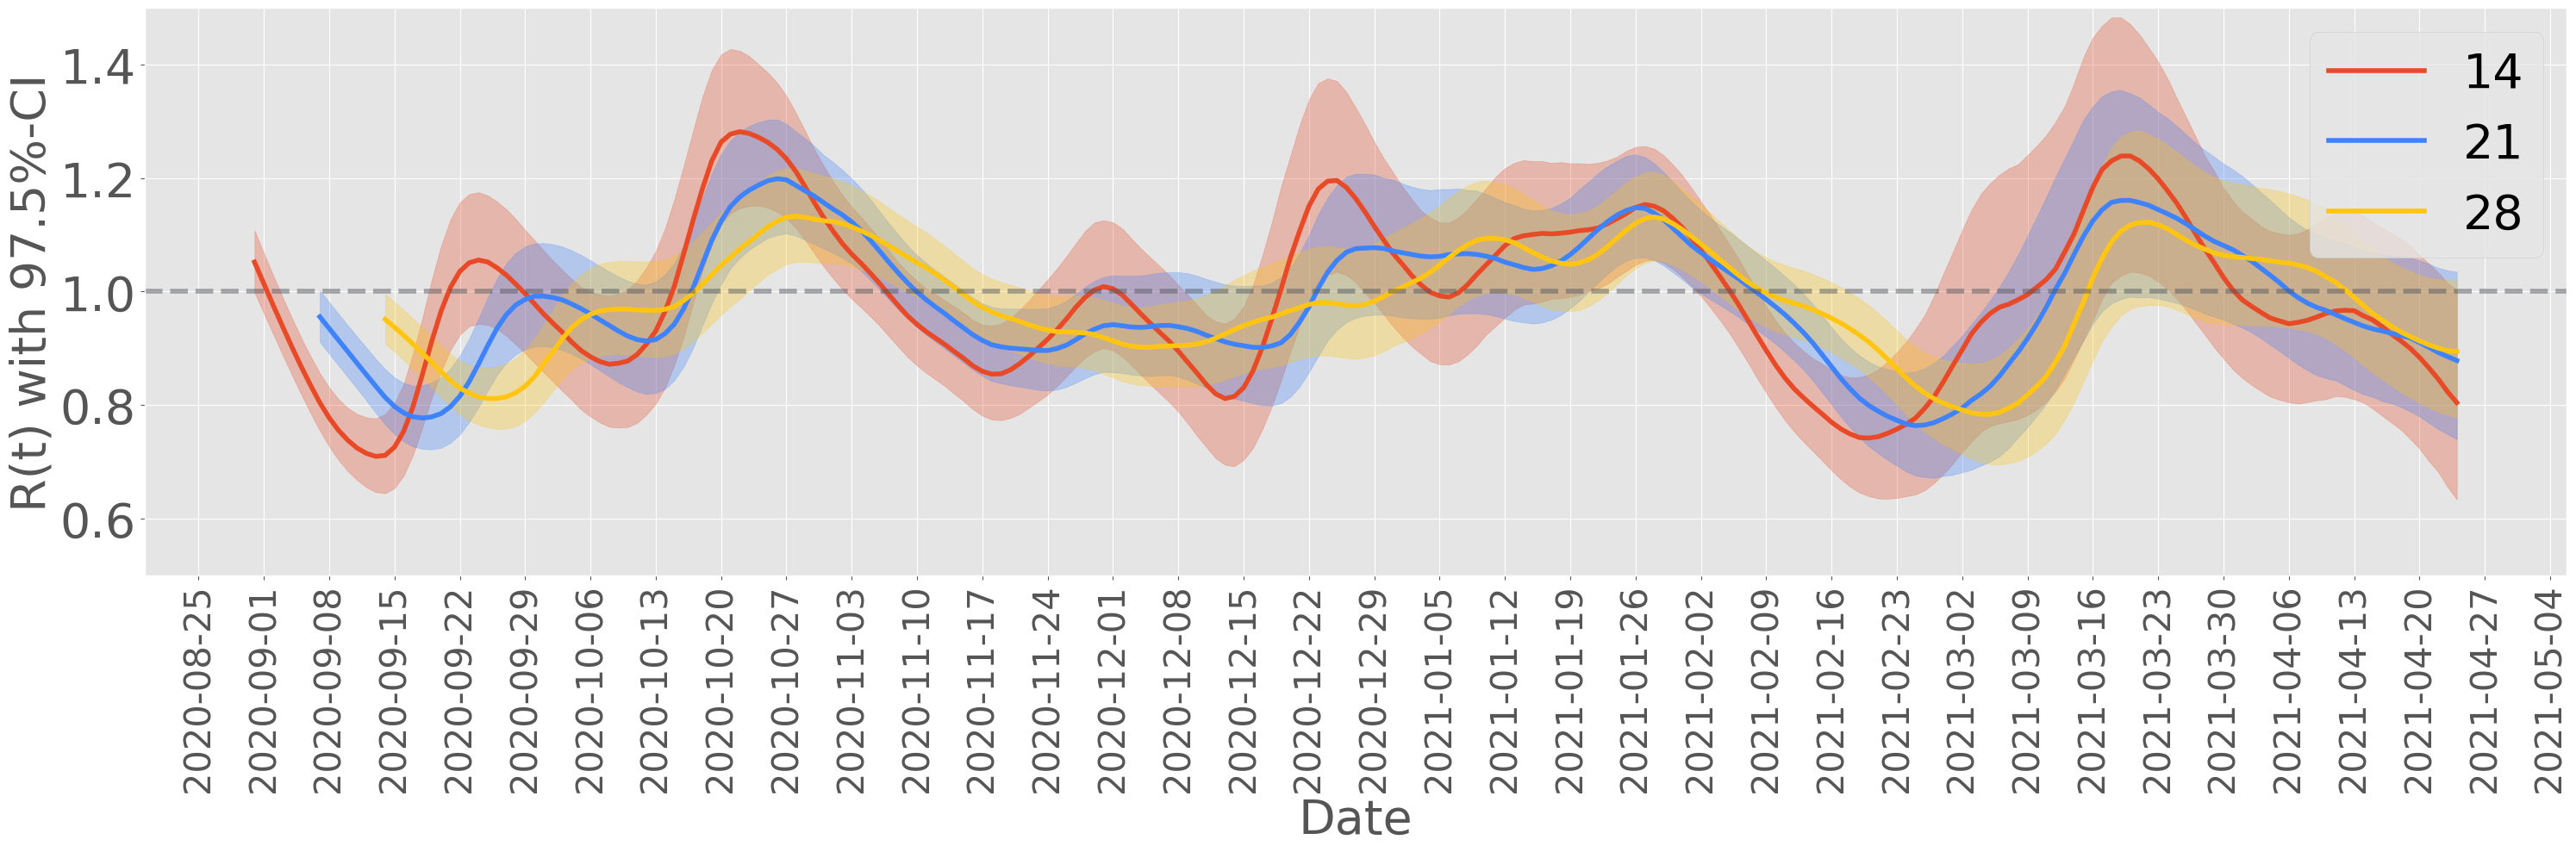

In [11]:
fig, uiuc_plot = plt.subplots(1,1, figsize=(30, 10))
uiuc_plot.plot(UIUC_R.index, UIUC_R.loc[:,'Q0.5'],linewidth=4,color=(232/255, 74/255, 39/255),label="14")
uiuc_plot.plot(UIUC_R_1.index, UIUC_R_1.loc[:,'Q0.5'],linewidth=4,color='#3e82fc',label="21")
uiuc_plot.plot( UIUC_R_2.index, UIUC_R_2.loc[:,'Q0.5'],linewidth=4,color='#FFc512',label="28")
uiuc_plot.fill_between(UIUC_R.index,
                    UIUC_R['Q0.025'],
                    UIUC_R['Q0.975'],
                    #color=(255/255, 235/255, 140/255), alpha=0.3)
                    color=(232/255, 74/255, 39/255), alpha=0.3)
uiuc_plot.fill_between(UIUC_R_1.index,
                    UIUC_R_1['Q0.025'],
                    UIUC_R_1['Q0.975'],
                    #color=(255/255, 235/255, 140/255), alpha=0.3)
                    color='#3e82fc', alpha=0.3)
uiuc_plot.fill_between(UIUC_R_2.index,
                    UIUC_R_2['Q0.025'],
                    UIUC_R_2['Q0.975'],
                    #color=(255/255, 235/255, 140/255), alpha=0.3)
                    color='#FFc512', alpha=0.3)
uiuc_plot.xaxis.set_major_locator(mdates.WeekdayLocator())
uiuc_plot.set_xlabel('Date', fontsize = 40)
uiuc_plot.set_ylabel('R(t) with 97.5%-CI', fontsize = 40)
uiuc_plot.set_ylim([0.5,1.5])
uiuc_plot.axhline(y=1,color=(85/255, 89/255, 96/255),linewidth=4,linestyle='dashed',alpha=0.5)
uiuc_plot.legend(fontsize = 40, )
uiuc_plot.tick_params(axis='x', rotation=90)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 40)
#uiuc_plot.set_title('Effective Reproduction Numbers of UIUC from Fall 2020 to Spring 2021', fontsize = 30)

In [13]:
# Reconstruction - Sensitivity Analysis
# reconstruct the spreading process in Fall 2020
UIUC_R= covid19.r_covid(UIUC_Total_Confirm,gt_distribution=serial_UIUC_New_U,smoothing_window=21, r_window_size=7)
uiuc_r_fall = UIUC_R.loc['2020-08-17':'2020-12-21','Q0.5']

serial_test = serial_UIUC_New/sum(serial_UIUC_New)
Scalor_UIUC = sum(serial_UIUC_New)/sum(serial_UIUC)
Scalor = Scalor_UIUC   #fixed scaling factor

Scalor_New = sum(serial_UIUC_New)/sum(serial_UIUC)
Scalor_Rel= Scalor/Scalor_New
df_infection_data_no_total = pd.DataFrame()
confirmed_cases_no_total = pd.DataFrame()


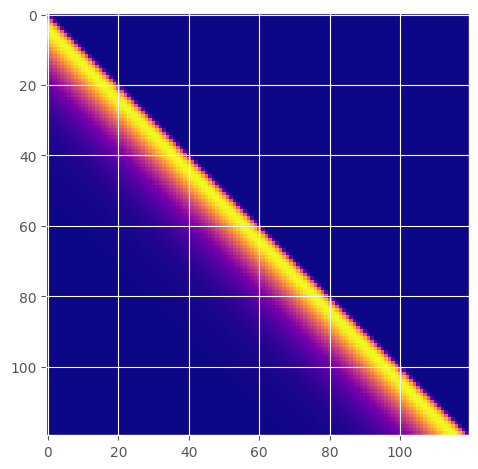

In [14]:
import scipy.linalg as la
delay_distrb = covid19.generate_standard_infection_to_reporting_distribution()
bs_confirmed_cases = bootstrap.bootstrap_series(UIUC_Total_Confirm)
sm_bs_confirmed_cases = smoothen.smoothen_series(bs_confirmed_cases, 14)
max_likelihood_infections = deconvolution.deconvolve_series(sm_bs_confirmed_cases,delay_distrb)

col = delay_distrb[:120]
row = np.concatenate(([delay_distrb[0]], np.zeros(120 - 1)), axis=None)

delay_kernel = la.toeplitz(col, row)
plt.imshow(delay_kernel[:, :], cmap='plasma')

In [15]:
Testing_Range = [0, 0.1, 0.2,0.3, 0.4,0.5,0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]

In [16]:
for k in Testing_Range:
        # change the testing rate from 1/7 to 0.5/7; 0.3/7; 0.1/7; 0.05/7; Then we can do adaptive testing
        # Constructing infection profile under_baseline testing rate
        serial_UIUC_New = functions._infection_update(testing_rate = 1-k/7, serial_interval = serial_UIUC)
        serial_test = serial_UIUC_New/sum(serial_UIUC_New)
        Scalor_New = sum(serial_UIUC_New)/sum(serial_UIUC)
        
        print (Scalor_New)
        
        # change infection profile to serial interval
        serial_UIUC_U=serial_UIUC_New / sum(serial_UIUC_New)
        #delete the first day
        serial_UIUC_U = np.delete(serial_UIUC_U, [0])
        #Important 
        #Scalor_Rel= Scalor/Scalor_New
        Scalor_Rel= Scalor_New

        N_Data_Len = 120
        true_r = uiuc_r_fall                               # Assign true reproduction numbers, estimated from UIUC's data
        seed_update = [40, 50, 80, 40, 86, 82, 143, 148, 164,88]            # Initial Conditions; Update recursively
        seed_update_no = [40, 50, 80, 40, 86, 82, 143, 148, 164,88] 
        # Define a function of generating synthetic data



        # Updating frequency

        Frequency=14
        Update_Frequency = list(range(0, N_Data_Len+Frequency, Frequency)); #construct time-window

        #initiate the simulation from the first round 
        incidence_ts = functions._synthetic_infections_U(
                #seed=[26, 21, 30, 56, 57,44, 53, 83, 89, 54, 47, 63, 49, 104, 231, 197,120, 87], r_ts=true_r
                # seed=[26, 21, 30, 56, 57,44, 53, 83, 231, 197,120] (important, to generate the same infection trend as UIUC)
            seed=seed_update, r_ts=true_r[0:Frequency], SI_interval= serial_UIUC_U
        )

        # first round simulated data incidence_ts

        infection_mid = incidence_ts.tolist() #convert pd.series to list
        infection_data = infection_mid        #pass data 
        seed_update = infection_data[-len(serial_UIUC_U):]  #update initial conditions


        # first round simulated data incidence_ts_no

        incidence_ts_no = functions._synthetic_infections_U(
                #seed=[26, 21, 30, 56, 57,44, 53, 83, 89, 54, 47, 63, 49, 104, 231, 197,120, 87], r_ts=true_r
                # seed=[26, 21, 30, 56, 57,44, 53, 83, 231, 197,120] (important, to generate the same infection trend as UIUC)
            seed=seed_update_no, r_ts=true_r[0:Frequency], SI_interval= serial_UIUC_U
        )

        infection_mid_no= incidence_ts_no.tolist() #convert pd.series to list
        infection_data_no= infection_mid_no     #pass data 
        seed_update_no= infection_data_no[-len(serial_UIUC_U):]  #update initial conditions

        total_I_No_T = sum(infection_data_no)
        seed_update_no=infection_data_no[-len(serial_UIUC_U):]
        total_I_No_T_Update = sum(infection_data)
        total_I_now_Update= sum(infection_data_no)
        Multiplier=Scalor #later stage, change it when changing control input; now it is a constant
        Total_pop = 50000



        for i in Update_Frequency[2::]:

            # 1. Simulating UIUC spreading Processes with testing strategy
            incidence_ts = functions._synthetic_infections_U(
                #seed=[26, 21, 30, 56, 57,44, 53, 83, 89, 54, 47, 63, 49, 104, 231, 197,120, 87], r_ts=true_r
                # seed=[26, 21, 30, 56, 57,44, 53, 83, 231, 197,120] (important, to generate the same infection trend as UIUC)
                seed=seed_update, r_ts=true_r[i+1-Frequency:i], SI_interval= serial_UIUC_U
            ) 
            infection_mid = incidence_ts.tolist() #convert pd.series to list
            infection_data.extend(infection_mid)
            seed_update = infection_mid[-len(serial_UIUC_U):]

            # 2. Simulating UIUC spreading Processes without testing strategy


            infection_data_pass=infection_data
            total_I_now = sum(infection_data_pass)

            incidence_ts_no= functions._synthetic_infections_Rt(
                seed=seed_update_no, r_ts=true_r[i+1-Frequency:i],serial_UIUC_U= serial_UIUC_U,total_I_No_T=total_I_No_T_Update,total_I_now=sum(infection_data_pass),Total_pop=50000, Multiplier=Scalor_Rel
            ) 
            infection_mid_no = incidence_ts_no.tolist() #convert pd.series to list
            infection_data_no.extend(infection_mid_no)
            seed_update_no= infection_mid_no[-len(serial_UIUC_U):]

            total_I_No_T_Update = sum(infection_data_no)

            #============================================add delay for data with testing===========================================================

            # output synthetic data: infection_data

            df_infection_data = pd.DataFrame (infection_data, columns = [''])    #convert list into dataframe
            df_infection_data= df_infection_data.squeeze() #convert  dataframe into data.series

            # from infected cases to confirmed cases

            col = delay_distrb[:len(df_infection_data)]
            row = np.concatenate(([delay_distrb[0]], np.zeros(len(df_infection_data)-1)), axis=None)
            delay_kernel = la.toeplitz(col, row)



            #compute confirmed cases

            confirmed_expected = delay_kernel @ df_infection_data
            confirmed_noise = np.random.normal(0, 1, size=len(df_infection_data))/10
            week_pattern = np.sin(2*np.pi*np.arange(len(df_infection_data))/7)/5

            confirmed_cases = pd.Series(confirmed_expected*(1 + confirmed_noise + week_pattern), index=df_infection_data.index).astype(int)

            #============================================add delay for data without testing===========================================================
             # output synthetic data: infection_data

            df_infection_data_no = pd.DataFrame (infection_data_no, columns = [''])    #convert list into dataframe
            df_infection_data_no= df_infection_data_no.squeeze() #convert  dataframe into data.series

            # from infected cases to confirmed cases

            col = delay_distrb[:len(df_infection_data)]
            row = np.concatenate(([delay_distrb[0]], np.zeros(len(df_infection_data)-1)), axis=None)
            delay_kernel = la.toeplitz(col, row)



            #compute confirmed cases

            confirmed_expected_no = delay_kernel @ df_infection_data_no
            confirmed_noise_no= np.random.normal(0, 1, size=len(df_infection_data_no))/10
            week_pattern_no= np.sin(2*np.pi*np.arange(len(df_infection_data_no))/7)/5

            confirmed_cases_no= pd.Series(confirmed_expected_no*(1 + confirmed_noise_no + week_pattern_no), index=df_infection_data_no.index).astype(int)

        #add the simulation results to the existing data 
        df_infection_data_no_total = pd.concat([df_infection_data_no_total,df_infection_data_no], axis=1)
        confirmed_cases_no_total = pd.concat([confirmed_cases_no_total,confirmed_cases_no], axis=1)

1.0
0.9566009026279527
0.9148924894190029
0.8748071404360241
0.8362802490613347
0.7992500856761844
0.7636576668005098
0.729446629524277
0.69656311106507
0.6649556332899146
0.6345749920426037
0.5773081407525504
0.5244104858768828
0.4755600090654608
0.43046196024568906
0.3888463152640313


In [17]:
df_infection_data_no_total = df_infection_data_no_total.iloc[: , 0:]
confirmed_cases_no_total = confirmed_cases_no_total.iloc[: , 0:]

In [18]:
Scalor_0 = 1.0*Scalor
Scalor_1 = 0.9566009026279527*Scalor
Scalor_2 = 0.9148924894190029*Scalor
Scalor_3 = 0.8748071404360241*Scalor
Scalor_4 = 0.8362802490613347*Scalor
Scalor_5 = 0.7992500856761844*Scalor
Scalor_6 = 0.7636576668005098*Scalor
Scalor_7 = 0.729446629524277*Scalor
Scalor_8 = 0.69656311106507*Scalor
Scalor_9 = 0.6649556332899146*Scalor
Scalor_10 = 0.6345749920426037*Scalor

In [19]:
date_updated = pd.Series(pd.date_range("2020-08-17", freq="D", periods=len(confirmed_cases_no_total)))
confirmed_cases_no_total = pd.concat([date_updated, confirmed_cases_no_total], axis=1)
#confirmed_cases_no_total = confirmed_cases_no_total.rename(columns={0: "Date", 1: "0%", 2: "10%", 3: "20%", 4: "30%", 5: "40%", 6: "50%", 7: "60%", 8: "70%", 9: "80%", 10: "90%", 11: "100%", 12: "110%",13: "120%", 14: "130%", 15: "140%",16: "150%"})
confirmed_cases_no_total = confirmed_cases_no_total.set_axis(['Date','0%', '10%', '20%', '30%', '40%','50%', '60%', '70%', '80%', '90%','100%', '120%', '140%', '160%', '180%','200%'], axis=1, copy=False)
#confirmed_cases_no_total = confirmed_cases_no_total.set_axis(['Date','0%', '20%', '40%','60%', '80%', '100%', '120%', '160%','180%', '200%'], axis=1, inplace=False)
confirmed_cases_no_total =  confirmed_cases_no_total.set_index('Date')

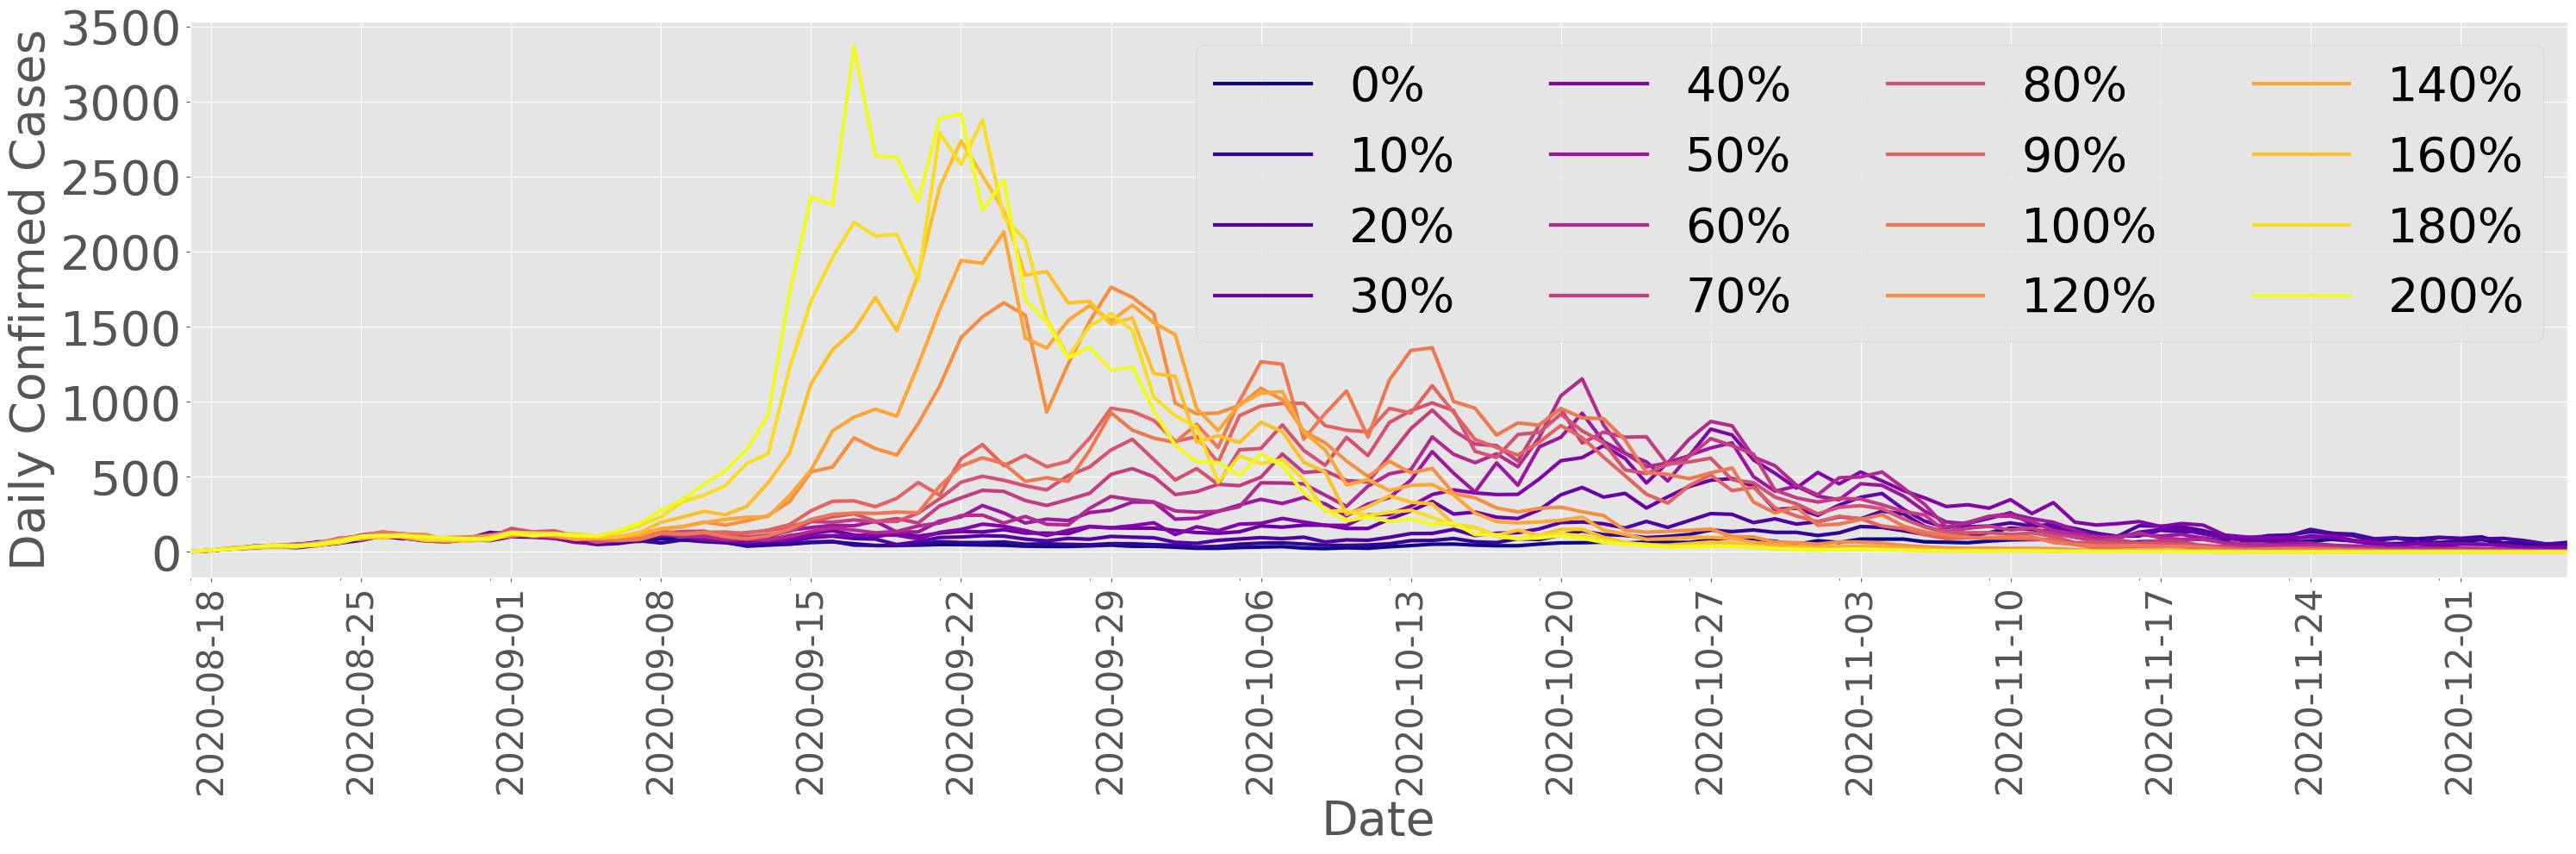

In [20]:
fig, ax = plt.subplots(figsize=(30,10))
#df_infection_data.plot(ax=ax, label='infected')
#df_infection_data_no_total.plot(ax=ax, label='infected_w/o')
#confirmed_cases.plot(ax=ax, label='confirmed')
confirmed_cases_no_total.plot(ax=ax, label='confirmed_w/o',linewidth=3, cmap = "plasma")

ax.set_ylabel("Daily Confirmed Cases")
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='x', rotation=90)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 40)
#ax.set_title('Daily Confirmed Cases at UIUC with Different Testing Rates', fontsize = 30)
ax.set_ylabel('Daily Confirmed Cases')
ax.set_xlabel('Date')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)
ax.legend(ncol=4, prop={'size':40})
plt.show()

In [21]:
true_r_list = true_r.values.tolist()
infection_data_no = confirmed_cases_no_total["0%"].values.tolist()
R_wo_test = functions._Rt_update(R_Test = true_r_list, Daily_infection_1 = infection_data_no, Daily_infection_2 = infection_data, Scaling_factor = Scalor, Population = Total_pop)
R_wo_test_pd = pd.DataFrame (R_wo_test, columns = [''])
R_direct =true_r/Scalor

In [22]:
df_infection_data_no_cumul=pd.Series.cumsum(df_infection_data_no_total)
confirmed_cases_no_cumul=pd.Series.cumsum(confirmed_cases_no_total)

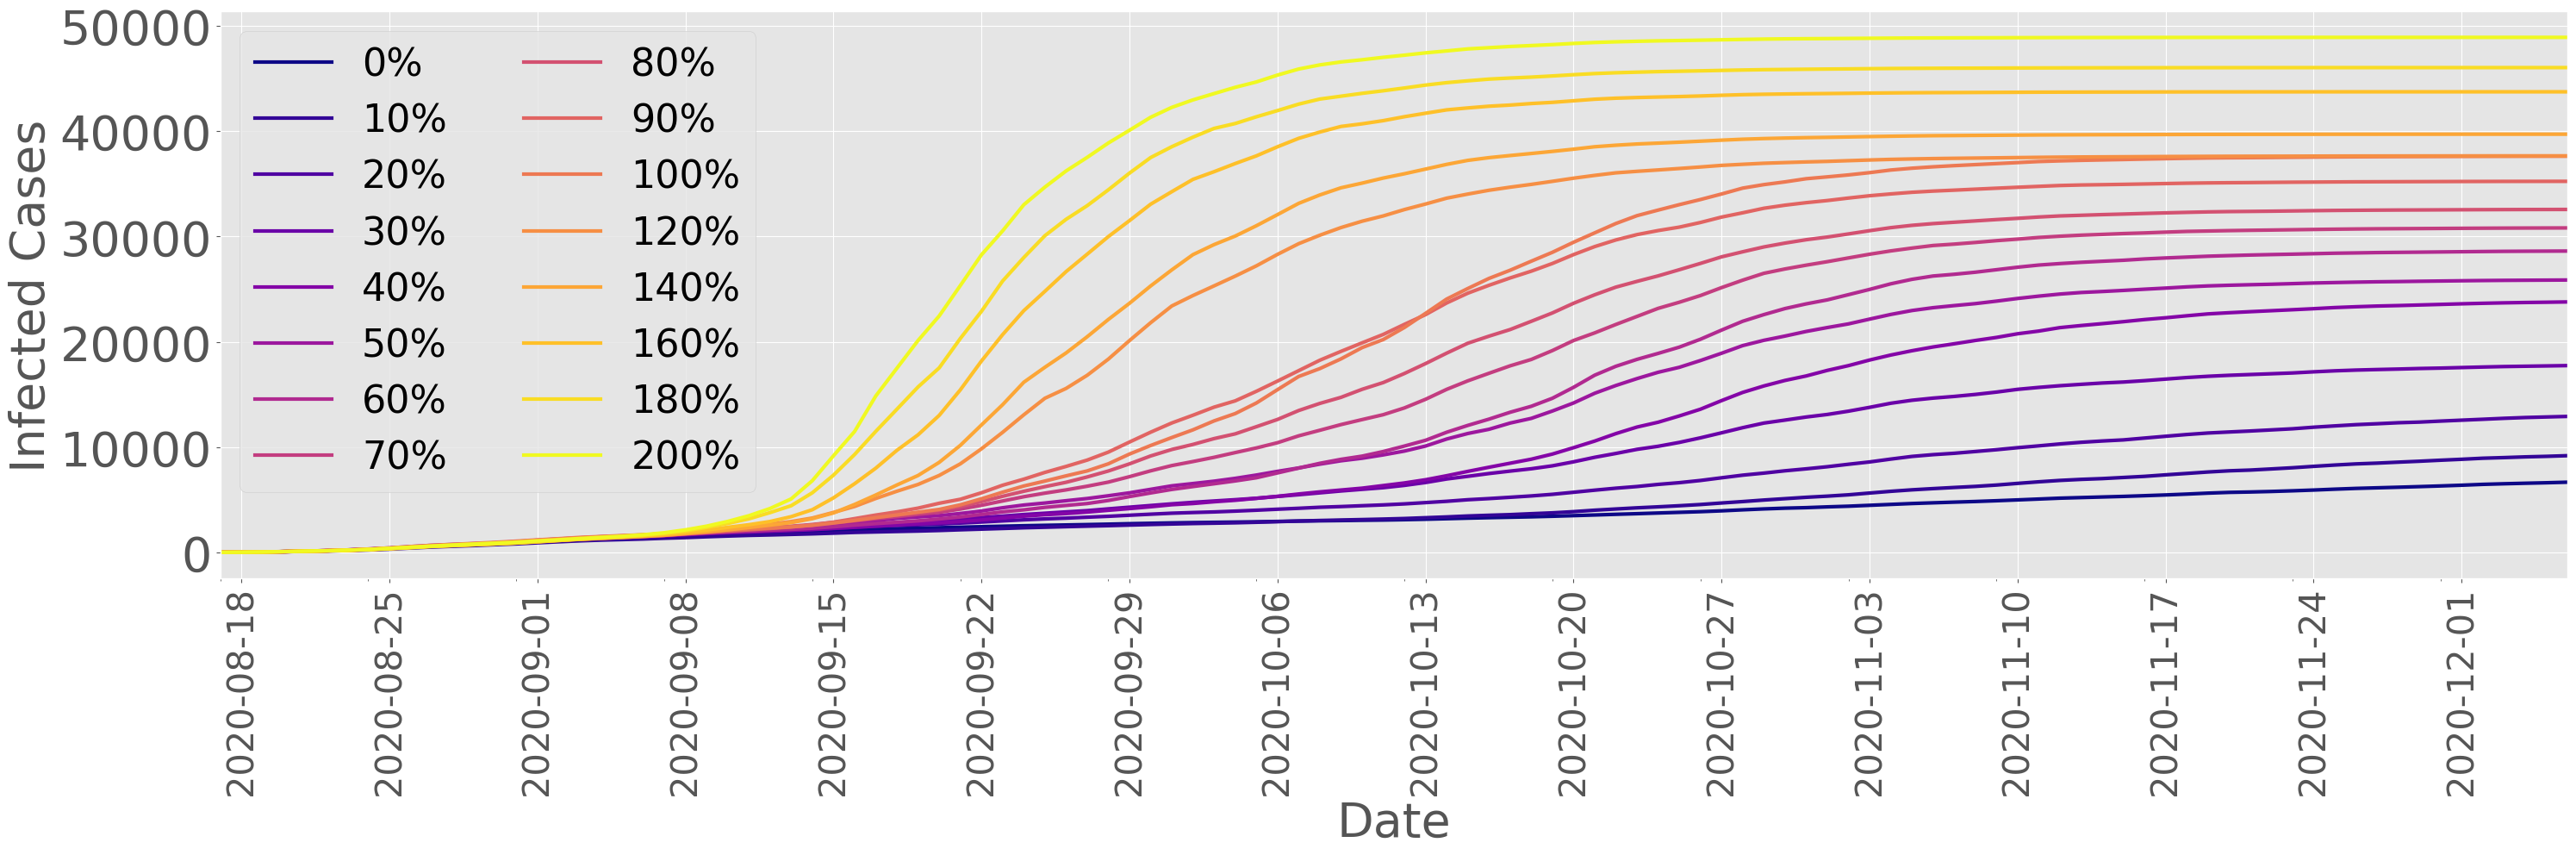

In [23]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(30,10))
#df_infection_data.plot(ax=ax, label='infected')
#df_infection_data_no_total.plot(ax=ax, label='infected_w/o')
#confirmed_cases.plot(ax=ax, label='confirmed')
confirmed_cases_no_cumul.plot(ax=ax, label='confirmed_w/o',linewidth=3, cmap = "plasma")
ax.set_ylabel("Daily infections and confirmed cases")
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.tick_params(axis='x', rotation=90)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 40)
#ax.set_title('Infected Cases at UIUC with Different Testing Rates (Mixed Symptomatic and Asymptomatic Infection)', fontsize = 15)
ax.set_ylabel('Infected Cases')
ax.set_xlabel('Date')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)
ax.legend(ncol = 2, prop={'size':32})
plt.show()

In [24]:
#Plot Heat Map
# Define the function to change date format

from collections.abc import Iterable
from sklearn import linear_model

class AxTransformer:
    def __init__(self, datetime_vals=False):
        self.datetime_vals = datetime_vals
        self.lr = linear_model.LinearRegression()
        
        return
    
    def process_tick_vals(self, tick_vals):
        if not isinstance(tick_vals, Iterable) or isinstance(tick_vals, str):
            tick_vals = [tick_vals]
            
        if self.datetime_vals == True:
            tick_vals = pd.to_datetime(tick_vals).astype('int64').values

        tick_vals = np.array(tick_vals)
            
        return tick_vals
    
    def fit(self, ax, axis='x'):
        axis = getattr(ax, f'get_{axis}axis')()
        
        tick_locs = axis.get_ticklocs()
        tick_vals = self.process_tick_vals([label._text for label in axis.get_ticklabels()])
        
        self.lr.fit(tick_vals.reshape(-1, 1), tick_locs)
        
        return
    
    def transform(self, tick_vals):        
        tick_vals = self.process_tick_vals(tick_vals)
        tick_locs = self.lr.predict(np.array(tick_vals).reshape(-1, 1))
        
        return tick_locs
    
def set_date_ticks(ax, start_date, end_date, axis='x', date_format='%Y-%m-%d', **date_range_kwargs):
    dt_rng = pd.date_range(start_date, end_date, **date_range_kwargs)

    ax_transformer = AxTransformer(datetime_vals=True)
    ax_transformer.fit(ax, axis=axis)
    
    getattr(ax, f'set_{axis}ticks')(ax_transformer.transform(dt_rng))
    getattr(ax, f'set_{axis}ticklabels')(dt_rng.strftime(date_format))

    ax.tick_params(axis=axis, which='both', bottom=True, top=False, labelbottom=True)
    
    return ax

In [25]:
confirmed_cases_no_cumul = confirmed_cases_no_cumul.transpose()

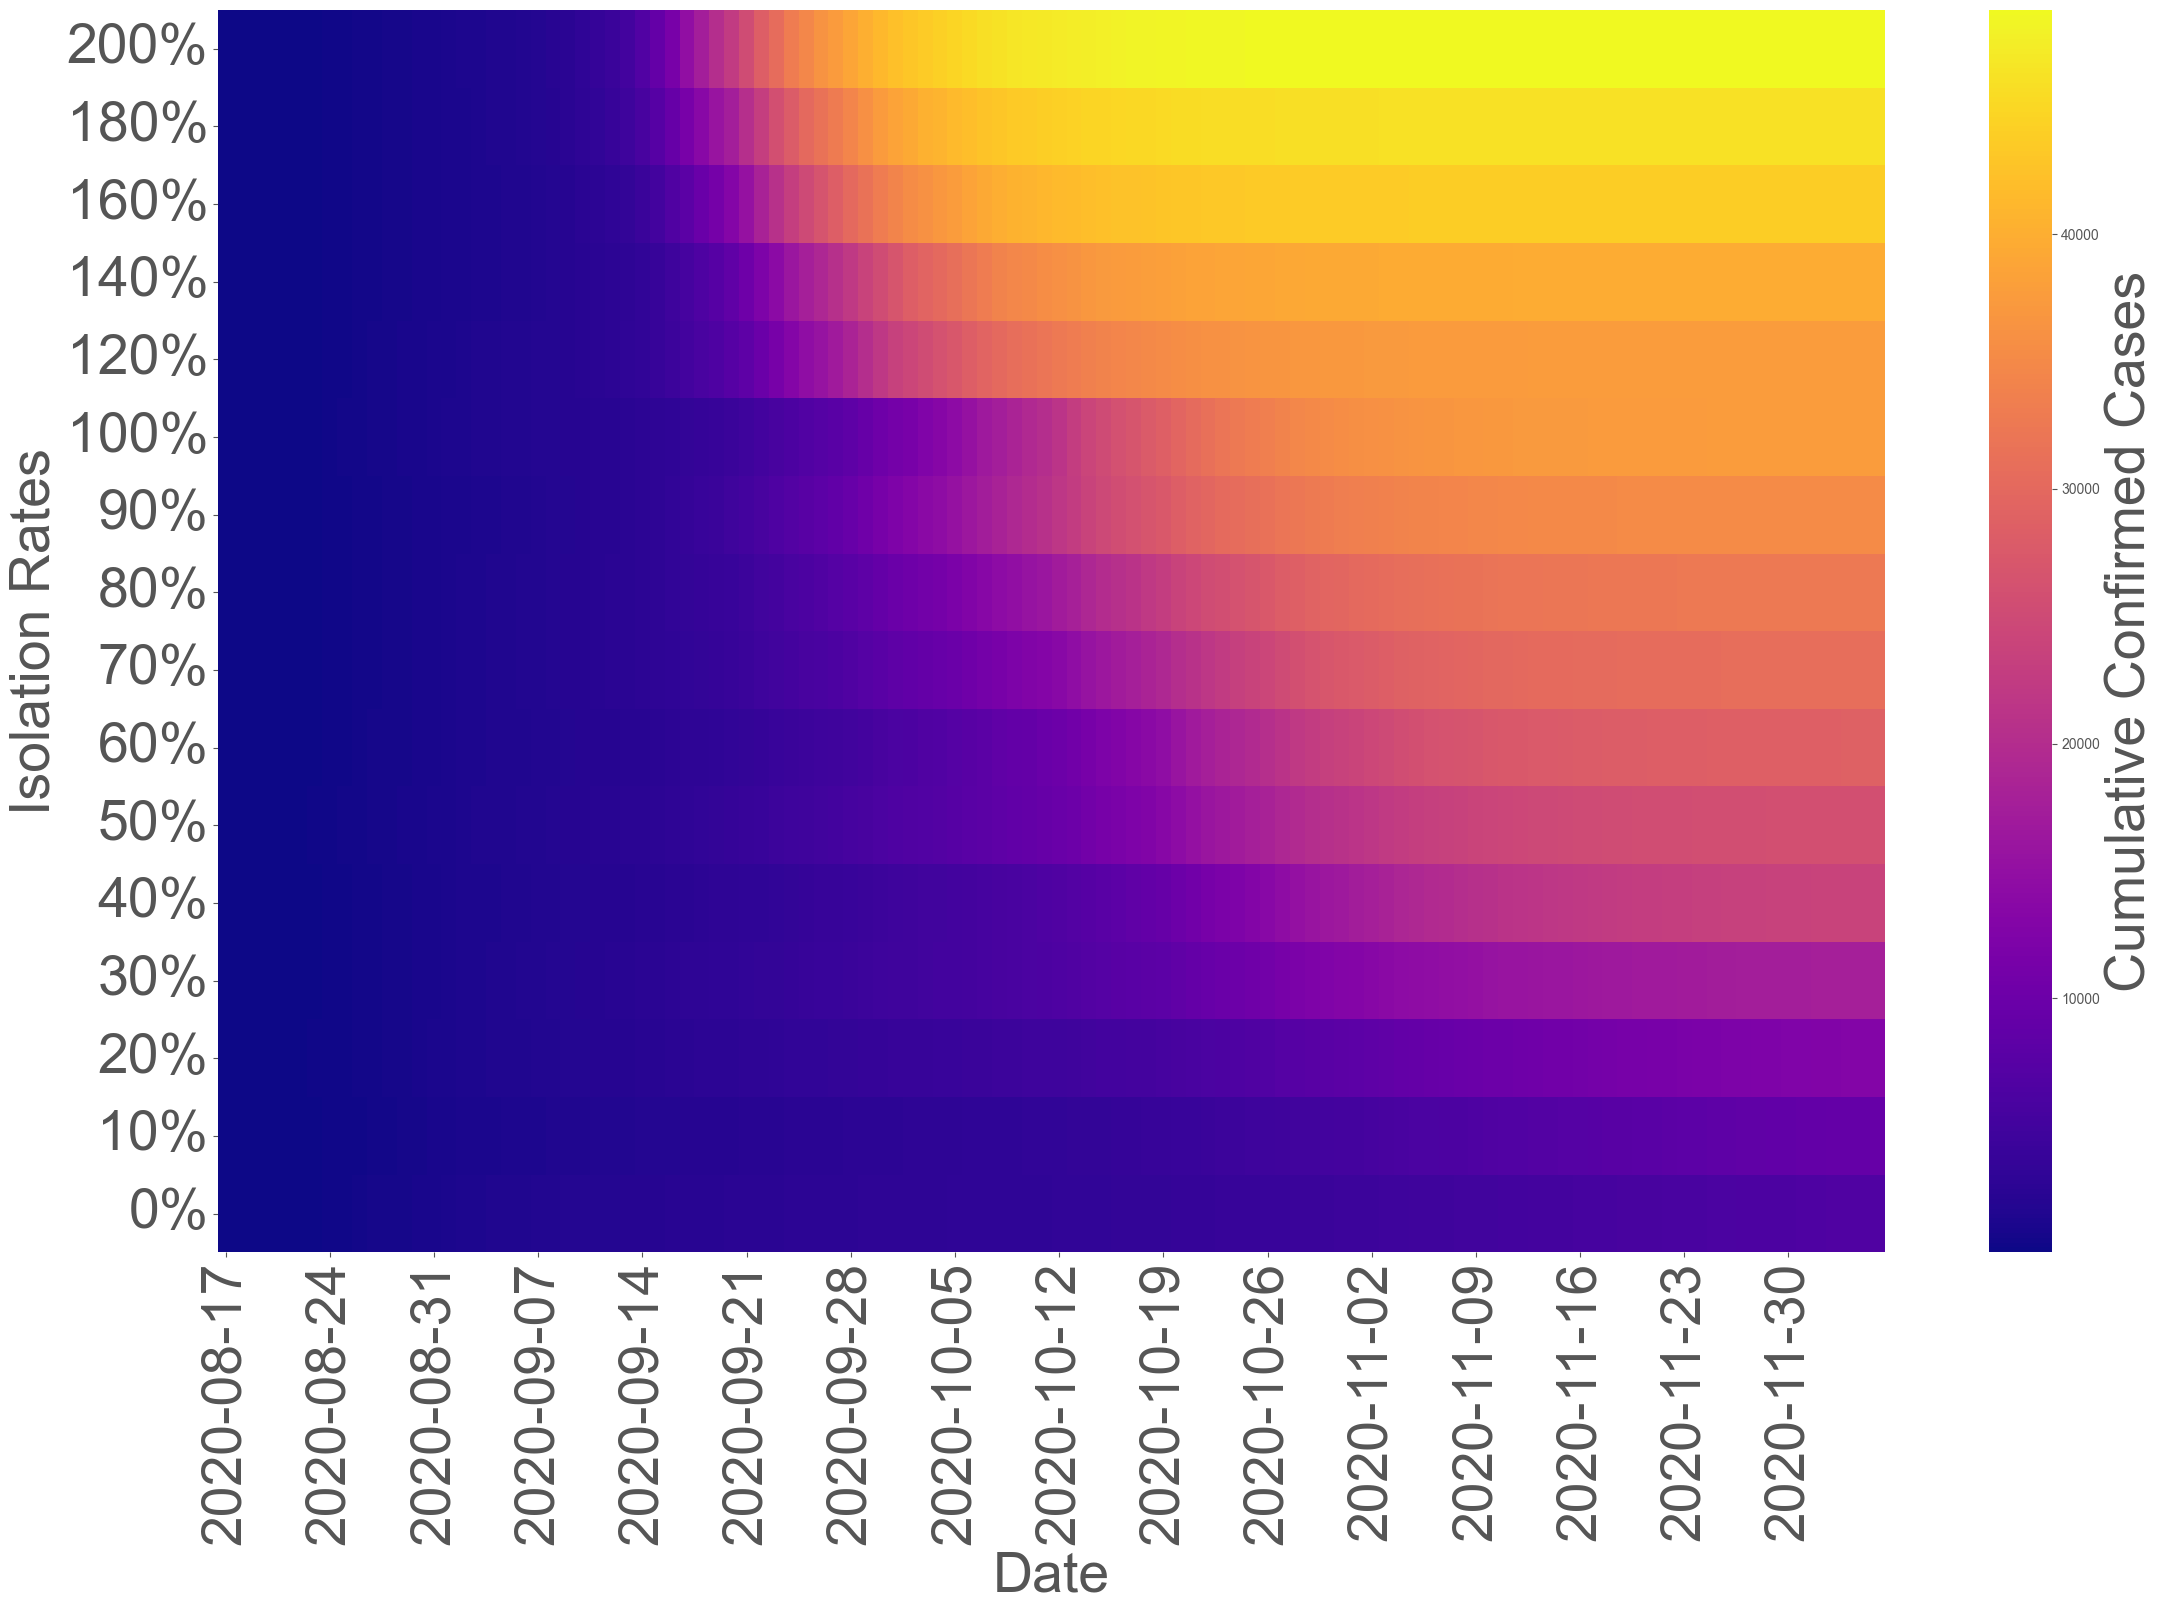

In [26]:
fig, ax1= plt.subplots(figsize=(24, 17))
sns.heatmap(confirmed_cases_no_cumul, cmap="plasma", robust=True, ax=ax1,cbar_kws={'label': 'Cumulative Confirmed Cases'})
sns.set(font_scale=3)
ax1.figure.axes[-1].yaxis.label.set_size(40)
ax1.set_ylabel("Isolation Rates", rotation=90)
plt.xticks(fontsize = 40)
ax1.tick_params(axis='y', rotation=360)
plt.yticks(fontsize = 40)
 
#ax1.set_title('Cumulated Infected Cases at UIUC', fontsize = 40)
ax1.set_xlabel('Date')
ax1.xaxis.label.set_size(40)
#ax1.tick_params(axis='x', rotation=45)                         
ax1.yaxis.label.set_size(40)
set_date_ticks(ax1, '2020-08-17', '2020-12-05', freq='7D')
ax1.invert_yaxis()
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()

In [27]:
confirmed_cases_no_total = confirmed_cases_no_total.transpose()

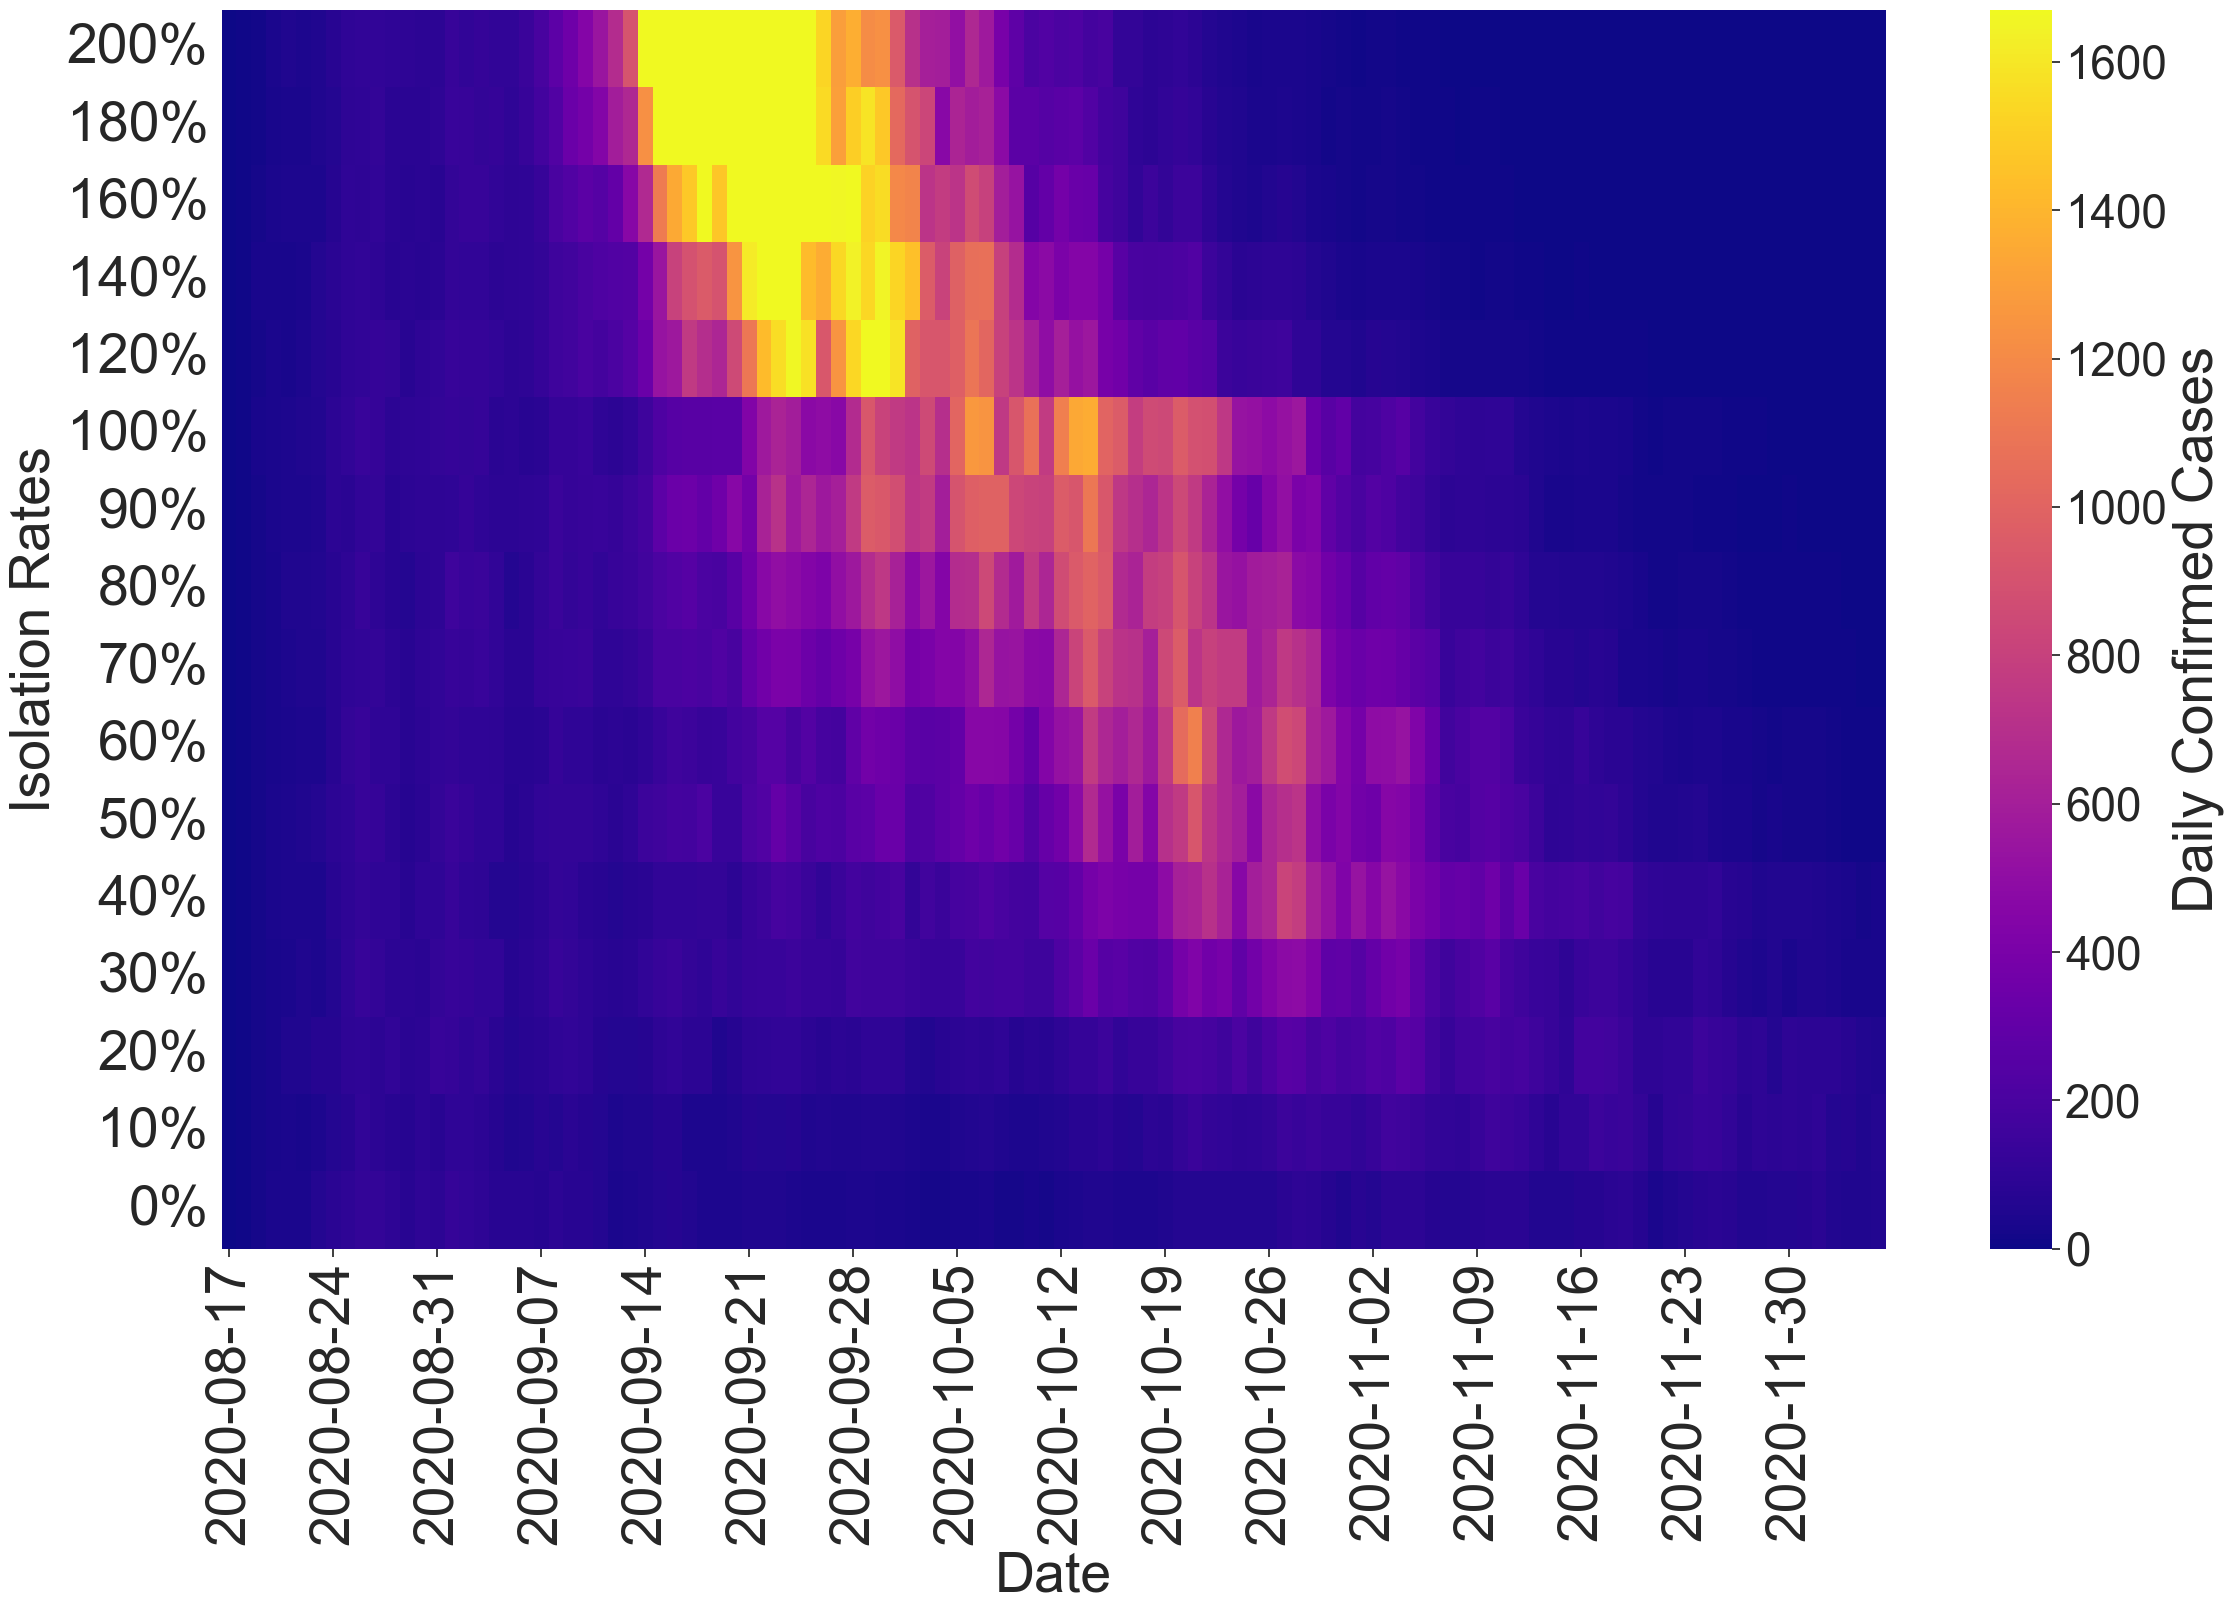

In [28]:
fig, ax1= plt.subplots(figsize=(24, 17))
sns.heatmap(confirmed_cases_no_total, cmap="plasma", robust=True, ax=ax1,cbar_kws={'label': 'Daily Confirmed Cases'})
ax1.set_xlabel("Date")
ax1.figure.axes[-1].yaxis.label.set_size(40)
plt.xticks(fontsize = 40)
plt.yticks(fontsize = 40)
ax1.set_ylabel('Isolation Rates')
ax1.xaxis.label.set_size(40)
ax1.yaxis.label.set_size(40)
ax1.invert_yaxis()
ax1.tick_params(axis='y', rotation=360)
ax1.tick_params(axis='x', rotation=90) 
set_date_ticks(ax1, '2020-08-17', '2020-12-05', freq='7D')
plt.show()